# Mega-millions 

## Steps
* We have a csv file.
* We are using one of the models. 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

## Prepare the data.

### Raw data

In [2]:
all_data = pd.read_csv('/Users/sam/Downloads/megamillions.csv')

In [3]:
all_data.head

<bound method NDFrame.head of       Mega Millions  12   5  2003  12.1  44  15  18   1  42  4
0     Mega Millions  12   9  2003    14  15  48   4  24  41  4
1     Mega Millions  12  12  2003    16  32  46   9  45  26  4
2     Mega Millions  12  16  2003    47  16  31  24  46  47  3
3     Mega Millions  12  19  2003     5  10  39  17  35  38  3
4     Mega Millions  12  23  2003     2  49  13  21  22  52  4
...             ...  ..  ..   ...   ...  ..  ..  ..  ..  .. ..
2147  Mega Millions   7   5  2024    32  54   6  15  67   4  3
2148  Mega Millions   7   9  2024    64  26  54  60  21   3  3
2149  Mega Millions   7  12  2024    35  48  53  15  68   8  3
2150  Mega Millions   7  16  2024     5  58  66  42  35  22  2
2151  Mega Millions   7  19  2024    10  17  23  50  67   3  3

[2152 rows x 11 columns]>

In [4]:
print(all_data.columns)

Index(['Mega Millions', '12', '5', '2003', '12.1', '44', '15', '18', '1', '42',
       '4'],
      dtype='object')


### Rename columns

In [5]:
all_data.columns = ['Blah','Month','Day','Year','N1','N2','N3','N4','N5','MB','MU']

In [6]:
print(all_data.columns)

Index(['Blah', 'Month', 'Day', 'Year', 'N1', 'N2', 'N3', 'N4', 'N5', 'MB',
       'MU'],
      dtype='object')


### DateTime

In [7]:
all_data['date'] = pd.to_datetime(all_data[['Year','Month','Day']])

In [8]:
all_data.head()

Blah  Month  Day  Year  N1  N2  N3  N4  N5  MB  MU       date
0  Mega Millions     12    9  2003  14  15  48   4  24  41   4 2003-12-09
1  Mega Millions     12   12  2003  16  32  46   9  45  26   4 2003-12-12
2  Mega Millions     12   16  2003  47  16  31  24  46  47   3 2003-12-16
3  Mega Millions     12   19  2003   5  10  39  17  35  38   3 2003-12-19
4  Mega Millions     12   23  2003   2  49  13  21  22  52   4 2003-12-23

### Sort
Format changed on 2017 so need to only look at the data after that 

In [9]:
temp= all_data[all_data['Year'] == 2017].index[0]

# df[df['year'] == 2017].index[0]
temp

1364

In [10]:
df = all_data.iloc[temp:]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 1364 to 2151
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Blah    788 non-null    object        
 1   Month   788 non-null    int64         
 2   Day     788 non-null    int64         
 3   Year    788 non-null    int64         
 4   N1      788 non-null    int64         
 5   N2      788 non-null    int64         
 6   N3      788 non-null    int64         
 7   N4      788 non-null    int64         
 8   N5      788 non-null    int64         
 9   MB      788 non-null    int64         
 10  MU      788 non-null    int64         
 11  date    788 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 74.0+ KB


In [12]:
mb_df = df['MB']
mb_df

1364    12
1365     6
1366    15
1367    11
1368     3
        ..
2147     4
2148     3
2149     8
2150    22
2151     3
Name: MB, Length: 788, dtype: int64

In [13]:
import matplotlib.pyplot as plt

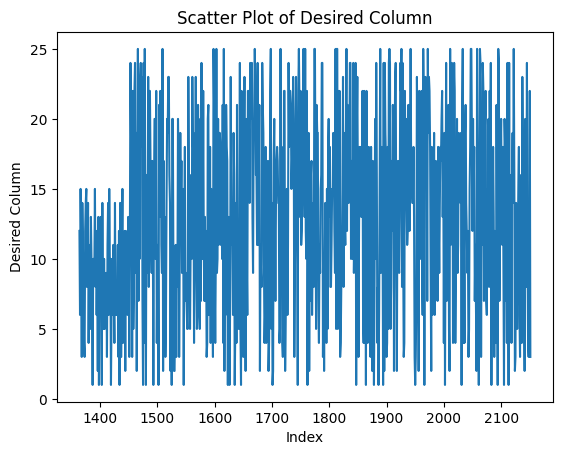

In [14]:
plt.plot(df.index, mb_df)
plt.xlabel('Index')
plt.ylabel('Desired Column')
plt.title('Scatter Plot of Desired Column')
plt.show()

(array([32., 25., 31., 37., 24., 30., 32., 25., 37., 36., 48., 33., 36.,
        36., 30., 24., 30., 35., 30., 28., 24., 38., 20., 35., 32.]),
 array([ 1.  ,  1.96,  2.92,  3.88,  4.84,  5.8 ,  6.76,  7.72,  8.68,
         9.64, 10.6 , 11.56, 12.52, 13.48, 14.44, 15.4 , 16.36, 17.32,
        18.28, 19.24, 20.2 , 21.16, 22.12, 23.08, 24.04, 25.  ]),
 [<matplotlib.patches.Polygon at 0x310903170>])

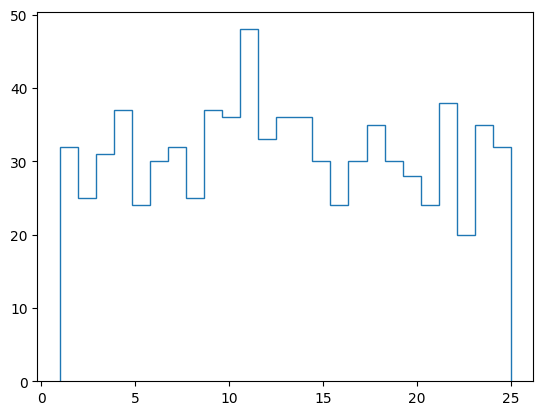

In [15]:
plt.hist(mb_df,bins=25, histtype='step')

# Separation

In [52]:
sequence = mb_df
train_sequence = sequence[:500]
test_sequence = sequence[500:]

In [53]:
mb_df[:500]

1364    12
1365     6
1366    15
1367    11
1368     3
        ..
1859     6
1860     4
1861    22
1862     4
1863    18
Name: MB, Length: 500, dtype: int64

# Markov Chain

In [59]:
# Function to predict the next number and update the sequence with predictions
# Function to build the transition matrix
def build_transition_matrix(sequence, num_states=25):
    transition_matrix = np.zeros((num_states, num_states))
    for (i, j) in zip(sequence[:-1], sequence[1:]):
        transition_matrix[i-1][j-1] += 1
    
    # Normalize to get probabilities
    transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
    return transition_matrix

# Function to predict the next number with weighted random choice
def predict_next(state, transition_matrix):
    probabilities = transition_matrix[state-1]
    next_number = np.random.choice(range(1, 26), p=probabilities)
    return next_number

def test_predictions_with_updates(test_sequence, transition_matrix):
    predictions = []

    # Initialize with the last number from the training sequence
    current_number = train_sequence.iloc[-1]

    for _ in test_sequence:
        predicted_number = predict_next(current_number, transition_matrix)
        predictions.append(predicted_number)
        # Update the current number to the predicted number for the next prediction
        current_number = predicted_number

    return predictions

In [60]:
# Build the transition matrix using the training sequence
transition_matrix = build_transition_matrix(train_sequence.values, 25)# Function to predict the next number and test the model

In [61]:
# Test the model with predictions being used for subsequent predictions
predictions = test_predictions_with_updates(test_sequence, transition_matrix)

# Compare predictions to actual test values
accuracy = np.mean(np.array(predictions) == test_sequence.values)

print(f"Model accuracy: {accuracy:.2%}")
print(f"Predictions: {predictions}")

Model accuracy: 3.47%
Predictions: [25, 5, 23, 24, 20, 19, 2, 6, 15, 23, 14, 2, 9, 2, 16, 10, 5, 25, 9, 15, 19, 13, 22, 21, 18, 4, 10, 24, 18, 4, 15, 8, 11, 16, 19, 14, 3, 14, 17, 9, 15, 5, 18, 17, 9, 12, 14, 9, 13, 1, 14, 1, 11, 1, 7, 23, 8, 19, 7, 1, 19, 7, 22, 19, 20, 11, 9, 10, 4, 14, 15, 1, 14, 20, 9, 8, 20, 20, 9, 25, 14, 5, 25, 25, 25, 22, 4, 13, 10, 9, 19, 2, 13, 18, 16, 17, 11, 3, 11, 24, 20, 20, 25, 5, 5, 5, 11, 19, 16, 10, 15, 6, 19, 18, 11, 3, 10, 10, 2, 6, 15, 8, 22, 2, 17, 18, 13, 1, 10, 11, 9, 25, 21, 6, 10, 6, 7, 9, 19, 13, 7, 1, 22, 21, 18, 19, 15, 5, 13, 22, 25, 21, 15, 19, 14, 20, 13, 7, 14, 15, 6, 11, 9, 4, 15, 19, 20, 25, 9, 5, 10, 17, 12, 14, 10, 22, 11, 1, 12, 3, 14, 10, 6, 7, 11, 6, 11, 15, 10, 6, 22, 24, 20, 25, 21, 6, 15, 3, 12, 1, 21, 9, 15, 22, 6, 10, 22, 9, 19, 14, 4, 22, 24, 24, 24, 11, 8, 22, 10, 5, 20, 3, 10, 7, 16, 10, 9, 15, 10, 2, 9, 18, 4, 20, 13, 1, 12, 15, 8, 4, 15, 22, 10, 25, 5, 5, 14, 6, 11, 19, 23, 9, 6, 21, 19, 23, 16, 16, 16, 18, 23, 15, 17, 

# RNN 

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator# Train the model


In [81]:
# Define sequence length for RNN input
sequence_length = 10  # You can adjust this

# **Subtract 1 to make labels in the range [0, 24]**
sequence = sequence - 1

train_sequence = sequence[:500].values  # Convert to NumPy array
test_sequence = sequence[500:].values  # Convert to NumPy array

# Reshape the data to be 2D (samples, features) as required by TimeseriesGenerator
train_sequence = train_sequence.reshape((-1, 1))

# Prepare the data using TimeseriesGenerator
train_generator = TimeseriesGenerator(train_sequence, train_sequence, length=sequence_length, batch_size=1)

# Build the RNN model with Input layer
model = Sequential()
model.add(Input(shape=(sequence_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(25, activation='softmax'))  # Output layer with 25 units for 25 classes

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [82]:
# Train the model
model.fit(train_generator, epochs=20)

Epoch 1/20
198/490 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - accuracy: 0.0297 - loss: 3.3456  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - accuracy: 0.0368 - loss: 3.3185
Epoch 2/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.0510 - loss: 3.2067
Epoch 3/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.0663 - loss: 3.1993
Epoch 4/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.0795 - loss: 3.1715
Epoch 5/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.0441 - loss: 3.1775
Epoch 6/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.0639 - loss: 3.1754
Epoch 7/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.0370 - loss: 3.1771
Epoch 8/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.0622 - loss: 3.1600
Epoch 9/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.0528 - loss: 3.1380
Epoch 10/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.0597 - loss: 3.1094
Epoch 11/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.0711 - loss: 3.1189
Epoch 12/20
490/490 ━━━━━━━━━━━━━━━━━━━━ 

In [88]:
def predict_next_with_randomness(state, model, sequence_length):
    # Reshape the sequence for prediction
    state = state.reshape((1, sequence_length, 1))
    predicted_probabilities = model.predict(state).flatten()
    
    # **Sample the next number using the predicted probabilities**
    next_number = np.random.choice(range(25), p=predicted_probabilities) + 1
    return next_number

In [89]:
# **Predict the next numbers with dynamic random weighting**
predictions = []
current_sequence = train_sequence[-sequence_length:]


In [92]:
for _ in range(len(test_sequence)):
    predicted_number = predict_next_with_randomness(current_sequence, model, sequence_length)
    predictions.append(predicted_number)

    # Update the current sequence
    current_sequence = np.append(current_sequence.flatten()[1:], predicted_number).reshape((-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1

In [86]:
# Evaluate accuracy
accuracy = np.mean(np.array(predictions) == test_sequence.flatten())
print(f"Model accuracy: {accuracy:.2%}")
print(f"Predictions: {predictions}")

Model accuracy: 6.25%
Predictions: [4, 4, 11, 15, 15, 15, 15, 22, 19, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17